In [42]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

import tensorflow as tf
import tensorflow_hub as hub
pd.set_option('display.max_colwidth', 200)

import time


# Read In Data

In [3]:
df = pd.read_csv('TrustPilot_ASOS_Reviews.csv')

# Basic Cleaning

In [4]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [5]:
df['clean_review'] = pre_process_corpus(df['review'])

In [7]:
df.head(2)

,review,rating,date,class,clean_review
0,"What has happened to ASOS?! I remembered a time when they used to be good. For my recent purchases- they sent me the wrong sizes. Instead of sorting it out, I get a message saying ‘we’ll be in ...",2,2018-11-08T18:14:32Z,1,what has happened to asos i remembered a time when they used to be good for my recent purchases they sent me the wrong sizes instead of sorting it out i get a message saying well be in touch in th...
1,"I pay for yearly next day delivery. I ordered my items on Thursday 26th September. I received no dispatch email on Friday 27th or Saturday 28th, so I then chased on Twitter. Who then said basicall...",1,2019-10-03T12:27:29Z,1,i pay for yearly next day delivery i ordered my items on thursday 26th september i received no dispatch email on friday 27th or saturday 28th so i then chased on twitter who then said basically wa...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['class'], test_size=0.2,random_state=42)

In [29]:
y_train.values

array([1, 0, 0, ..., 1, 0, 0])

In [33]:
tf.numpy_function.

<function tensorflow.python.ops.script_ops.numpy_function(func, inp, Tout, name=None)>

In [37]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': X_train.values}, y_train.values, batch_size=256, num_epochs=None, shuffle=True)
    
# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': X_train.values}, y_train.values, shuffle=False)
    
    
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': X_test.values}, y_test.values, shuffle=False) 

In [38]:
embedding_feature = hub.text_embedding_column(key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [273]:
import tensorflow_hub as hub_test

In [274]:
embed = hub_test.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embeddings = embed(['a','b'])

RuntimeError: Graph is finalized and cannot be modified.

In [64]:
dnn = tf.compat.v1.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.005))
          
          
# train for approx 12 epochs
# 256*1500 / 30000 == 12.8

W0604 11:58:21.922863 4501882304 estimator.py:1846] Using temporary folder as model directory: /var/folders/pl/2x57l04140v1p03x_sxgw2h00000gn/T/tmpu06yv3gn


In [67]:
# tf.logging.set_verbosity(tf.logging.ERROR)


TOTAL_STEPS = 500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
#     print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 46.73370003700256


W0604 12:12:35.869028 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:12:35.884196 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.96525717, 'accuracy_baseline': 0.53907025, 'auc': 0.9936323, 'auc_precision_recall': 0.9922363, 'average_loss': 0.09667601, 'label/mean': 0.46092978, 'loss': 12.31363, 'precision': 0.95343333, 'prediction/mean': 0.465065, 'recall': 0.972103, 'global_step': 800}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 43.62418818473816


W0604 12:13:39.796173 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:13:39.812654 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.96686447, 'accuracy_baseline': 0.53907025, 'auc': 0.99400616, 'auc_precision_recall': 0.9927455, 'average_loss': 0.09397224, 'label/mean': 0.46092978, 'loss': 11.969252, 'precision': 0.95347315, 'prediction/mean': 0.4668908, 'recall': 0.9757242, 'global_step': 900}

----------------------------------------------------------------------------------------------------
Training for step = 200
Train Time (s): 45.415151834487915


W0604 12:14:45.021156 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:14:45.039891 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.9674827, 'accuracy_baseline': 0.53907025, 'auc': 0.9942733, 'auc_precision_recall': 0.9930862, 'average_loss': 0.09091102, 'label/mean': 0.46092978, 'loss': 11.579344, 'precision': 0.9593054, 'prediction/mean': 0.4600835, 'recall': 0.97062767, 'global_step': 1000}

----------------------------------------------------------------------------------------------------
Training for step = 300
Train Time (s): 50.83906698226929


W0604 12:15:55.654169 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:15:55.671774 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.9682245, 'accuracy_baseline': 0.53907025, 'auc': 0.99458444, 'auc_precision_recall': 0.99353683, 'average_loss': 0.08960122, 'label/mean': 0.46092978, 'loss': 11.412514, 'precision': 0.9537255, 'prediction/mean': 0.4689559, 'recall': 0.9785408, 'global_step': 1100}

----------------------------------------------------------------------------------------------------
Training for step = 400
Train Time (s): 49.41320514678955


W0604 12:17:05.807353 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:17:05.825043 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.97051185, 'accuracy_baseline': 0.53907025, 'auc': 0.9948842, 'auc_precision_recall': 0.9937972, 'average_loss': 0.08563108, 'label/mean': 0.46092978, 'loss': 10.906837, 'precision': 0.9633515, 'prediction/mean': 0.4600901, 'recall': 0.97304183, 'global_step': 1200}

----------------------------------------------------------------------------------------------------
Training for step = 500
Train Time (s): 46.49541878700256


W0604 12:18:15.173557 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:18:15.202600 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Eval Metrics (Train): {'accuracy': 0.9716246, 'accuracy_baseline': 0.53907025, 'auc': 0.9951619, 'auc_precision_recall': 0.9941795, 'average_loss': 0.083259396, 'label/mean': 0.46092978, 'loss': 10.604755, 'precision': 0.96148264, 'prediction/mean': 0.4637612, 'recall': 0.97760195, 'global_step': 1300}


In [68]:
dnn.evaluate(input_fn=predict_test_input_fn)

W0604 12:19:22.128762 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0604 12:19:22.149579 4501882304 metrics_impl.py:812] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


{'accuracy': 0.9653808,
 'accuracy_baseline': 0.537092,
 'auc': 0.99263084,
 'auc_precision_recall': 0.9916724,
 'average_loss': 0.10268926,
 'label/mean': 0.462908,
 'loss': 12.977355,
 'precision': 0.95626974,
 'prediction/mean': 0.46425122,
 'recall': 0.96955127,
 'global_step': 1300}

In [225]:
X_test.values

array(['item did not arrive and customer service is the worse do not buy from them',
       'nice customer service abdirahman thank you',
       'pleasant and informing customer service agent all the information provided was as expected and it was very helpful',
       ...,
       'premium delivery used dhl who text and email prior to delivery to confirm what arrangements suit you as a result if i was not at home my parcel was left in a safe place now asos is using couriers please for its premium delivery there is nothing premium about this service whatsoever the first and only contact i had from the courier was to tell me that my parcel had been delivered to a shop and i had to go there and pick it up myself so for asos premium delivery i rate the service 110 until they use a proper courier service again as for asos customer service to resolve this issue i also rate them 110',
       'nice and helpful person',
       'order through hermes did not turn up after a week standard for herm

In [238]:
preds = dnn.predict(input_fn=tf.compat.v1.estimator.inputs.numpy_input_fn(x={"sentence": X_test.values}, y=None,shuffle=False))

In [240]:
b = preds

In [241]:
predicted_classes = [p for p in b]

In [248]:
type(predicted_classes[0])

dict

In [249]:
pred_labels = [x['class_ids'][0] for x in predicted_classes]

[1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,


In [185]:
test = np.array(['Absolutely wonderful service as per usual','Terrible service, will not be using again'])

In [186]:
test_input = tf.compat.v1.estimator.inputs.numpy_input_fn(x={"sentence": test}, y=None,shuffle=False)

In [187]:
predictions = dnn.predict(input_fn=test_input)
predicted_classes = [p for p in predictions]



In [188]:
predicted_classes

[{'logits': array([-7.1986475], dtype=float32),
  'logistic': array([0.00074704], dtype=float32),
  'probabilities': array([9.992530e-01, 7.470378e-04], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([5.9849954], dtype=float32),
  'logistic': array([0.99749005], dtype=float32),
  'probabilities': array([0.00250991, 0.99749005], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)}]

In [ ]:
print(
    "New Samples, Class Predictions:    {}\n"
    .format(predicted_classes))

In [125]:
dnn.export_saved_model('my_model') 

TypeError: export_saved_model() missing 1 required positional argument: 'serving_input_receiver_fn'

In [257]:
from sklearn.metrics import confusion_matrix as cm

array([[2089,   83],
       [  57, 1815]])

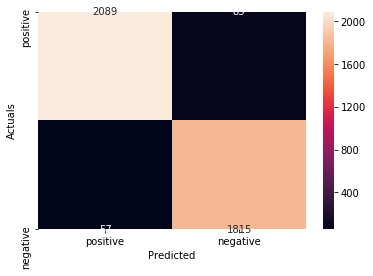

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline



LABELS = ['positive', 'negative']
sns.heatmap(cm(y_test.values, np.array(pred_labels)), annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [269]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test.values, 
                            y_pred=np.array(pred_labels), target_names=LABELS))

              precision    recall  f1-score   support

    positive       0.97      0.96      0.97      2172
    negative       0.96      0.97      0.96      1872

   micro avg       0.97      0.97      0.97      4044
   macro avg       0.96      0.97      0.97      4044
weighted avg       0.97      0.97      0.97      4044

